<br><br><br>


<span style="color:red;font-size:60px">PySpark Introduction with ML Practice</span>
<br><br><br>
In this notebook, we'll compare the results of a random forest classifier with the results from a logistic regression classifier on the California housing data. Working with python gives us access to easy graphics (matplotlib.pyplot) so we can draw ROC curves and precision-recall curves easily. We'll also get some practice with other feature transformers available in Spark.

Just follow the steps below - carefully - and you should not have a problem


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 1: Initialize PySpark</span>

In [171]:
#Pyspark initialization 
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Pyspark ML practice").getOrCreate()
sc = spark.sparkContext

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 2: necessary imports</span>


In [172]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 3: Read the data and split into training and testing sets</span>
<li>Convert the Scala Spark function into a PySpark function</li>

In [173]:
from pyspark.sql import DataFrame


def readData(): 
    df = spark.read.option('header', False)\
    .option("infersschema", True)\
    .csv("cal_housing.data")\
    .toDF("Longitude","Latitude","MedianAge",
                     "TotalRooms","TotalBedrooms","Population","Households",
                     "MedianIncome","MedianHomeValue")
    
    for c in df.columns:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    train,test = df.randomSplit((0.8,0.2),seed=1234)
    return train,test

train,test = readData()

In [174]:
train.printSchema()

root
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- MedianAge: double (nullable = true)
 |-- TotalRooms: double (nullable = true)
 |-- TotalBedrooms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Households: double (nullable = true)
 |-- MedianIncome: double (nullable = true)
 |-- MedianHomeValue: double (nullable = true)



In [175]:
train.show(5)

+---------+--------+---------+----------+-------------+----------+----------+------------+---------------+
|Longitude|Latitude|MedianAge|TotalRooms|TotalBedrooms|Population|Households|MedianIncome|MedianHomeValue|
+---------+--------+---------+----------+-------------+----------+----------+------------+---------------+
|  -124.35|   40.54|     52.0|    1820.0|        300.0|     806.0|     270.0|      3.0147|        94600.0|
|   -124.3|   41.84|     17.0|    2677.0|        531.0|    1244.0|     456.0|      3.0313|       103600.0|
|  -124.27|   40.69|     36.0|    2349.0|        528.0|    1194.0|     465.0|      2.5179|        79000.0|
|  -124.25|   40.28|     32.0|    1430.0|        419.0|     434.0|     187.0|      1.9417|        76100.0|
|  -124.23|   40.54|     52.0|    2694.0|        453.0|    1152.0|     435.0|      3.0806|       106700.0|
+---------+--------+---------+----------+-------------+----------+----------+------------+---------------+
only showing top 5 rows



<br><br><br>
<span style="color:green;font-size:xx-large">STEP 4: Write the prepareData function</span>
<li>Convert the Scala Spark function into a PySpark function</li>

In [176]:
from pyspark.sql import DataFrame


def prepareData(df): 
    df = df.withColumn("MedianHomeValue",col("MedianHomeValue")/100000)\
        .withColumn("RoomsPerHouse", col("TotalRooms")/col("Households"))\
        .withColumn("PeoplePerHouse", col("Population")/col("Households"))\
        .withColumn("BedroomsPerHouse", col("TotalBedrooms")/col("Households"))\
        .select('MedianAge',
                'Population',
                'Households',
                'MedianIncome',
                'RoomsPerHouse',
                'PeoplePerHouse',
                'BedroomsPerHouse',
                'Latitude',
                'Longitude',
                'MedianHomeValue',
             )
    #Rest of the code goes here

    
    
    return df

prepareData(train)

DataFrame[MedianAge: double, Population: double, Households: double, MedianIncome: double, RoomsPerHouse: double, PeoplePerHouse: double, BedroomsPerHouse: double, Latitude: double, Longitude: double, MedianHomeValue: double]

In [177]:
train.columns

['Longitude',
 'Latitude',
 'MedianAge',
 'TotalRooms',
 'TotalBedrooms',
 'Population',
 'Households',
 'MedianIncome',
 'MedianHomeValue']

In [178]:
train.printSchema()

root
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- MedianAge: double (nullable = true)
 |-- TotalRooms: double (nullable = true)
 |-- TotalBedrooms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Households: double (nullable = true)
 |-- MedianIncome: double (nullable = true)
 |-- MedianHomeValue: double (nullable = true)



<br><br><br>
<span style="color:green;font-size:xx-large">STEP 5: Transform the dependent variable into two buckets</span>

<li>Using QuantileDiscretizer with two buckets</li>
<li>QuantileDiscretizer bins a continuous column into n buckets across the range of values in that column</li>
<li>When n=2, we'll get 0 and 1 as the two values setting up the dv as a binary classification problem</li>
<li>Note: In this case, the interpretation of the dv is:
    <ul>
        <li>0: low median housing value</li>
        <li>1: high median housing value</li>
    </ul>
<li><a href="https://spark.apache.org/docs/latest/ml-features#quantilediscretizer">https://spark.apache.org/docs/latest/ml-features#quantilediscretizer</a></li>


In [179]:
discretizer = QuantileDiscretizer(numBuckets=2, inputCol="MedianHomeValue",
                                 outputCol="DVBucket")

bucketizer = discretizer.fit(prepareData(train))
bucketed = bucketizer.transform(prepareData(train))


In [180]:
bucketed.show(5)

+---------+----------+----------+------------+------------------+------------------+------------------+--------+---------+---------------+--------+
|MedianAge|Population|Households|MedianIncome|     RoomsPerHouse|    PeoplePerHouse|  BedroomsPerHouse|Latitude|Longitude|MedianHomeValue|DVBucket|
+---------+----------+----------+------------+------------------+------------------+------------------+--------+---------+---------------+--------+
|     52.0|     806.0|     270.0|      3.0147|6.7407407407407405|2.9851851851851854|1.1111111111111112|   40.54|  -124.35|          0.946|     0.0|
|     17.0|    1244.0|     456.0|      3.0313| 5.870614035087719|2.7280701754385963|1.1644736842105263|   41.84|   -124.3|          1.036|     0.0|
|     36.0|    1194.0|     465.0|      2.5179| 5.051612903225807| 2.567741935483871| 1.135483870967742|   40.69|  -124.27|           0.79|     0.0|
|     32.0|     434.0|     187.0|      1.9417| 7.647058823529412| 2.320855614973262|2.2406417112299466|   40.28|

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 6: Assemble the independent variables in a features vector</span>
<li>Use VectorAssembler for this</li>

In [181]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Matrix, Vectors

#Get the names of all columns except MedianHomeValue 
cols = prepareData(train).columns
cols.remove("MedianHomeValue")


#Create a vectorassembler from the list of columns and specify the name of the column of vectors
assembler = VectorAssembler(outputCol="features", inputCols=cols)

#Apply the transform function on the data frame, select the dv and features column
#And rename the dv column to label

vector_df = assembler.transform(prepareData(train))
# vector_df = bucketizer.transform(vector_df)
#             .select("features", "DVBucket")

vector_df.show()

+---------+----------+----------+------------+------------------+------------------+------------------+--------+---------+---------------+--------------------+
|MedianAge|Population|Households|MedianIncome|     RoomsPerHouse|    PeoplePerHouse|  BedroomsPerHouse|Latitude|Longitude|MedianHomeValue|            features|
+---------+----------+----------+------------+------------------+------------------+------------------+--------+---------+---------------+--------------------+
|     52.0|     806.0|     270.0|      3.0147|6.7407407407407405|2.9851851851851854|1.1111111111111112|   40.54|  -124.35|          0.946|[52.0,806.0,270.0...|
|     17.0|    1244.0|     456.0|      3.0313| 5.870614035087719|2.7280701754385963|1.1644736842105263|   41.84|   -124.3|          1.036|[17.0,1244.0,456....|
|     36.0|    1194.0|     465.0|      2.5179| 5.051612903225807| 2.567741935483871| 1.135483870967742|   40.69|  -124.27|           0.79|[36.0,1194.0,465....|
|     32.0|     434.0|     187.0|      1

<br><br><br><br>
<span style="color:red;font-size:40px">ML Models: Logistic Regression and Random Forest</span>
<br><br>
we'll build a logistic regression model and a random forest classifer and then compare the results on the two models. For this, we need to do the following:
<li>Create a pipeline for the logistic regression model</li>
<li>Create a pipeline for the random forest model</li>
<li>Evaluate and compare both models</li>
<li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html">https://spark.apache.org/docs/latest/ml-classification-regression.html</a></li>

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 7: Create the two classifers</span>



In [183]:
rrr = RandomForestClassifier()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")

logrr = LogisticRegression()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 8: Create the two pipelines</span>

<li>Create p1 with two stages: the bucketizer that uses QuantileDiscretizer and the assembler</li>
<li>Create p2 with two stages: p1 and logistic regression</li>
<li>Create p3 with two stages: p1 and random forest classifier</li>

In [184]:
p1 = Pipeline().setStages([bucketizer, assembler])
p2 = Pipeline().setStages([p1, logrr])
p3 = Pipeline().setStages([p1, rrr])

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 9: Run the two pipelines with training data</span>


In [185]:
lrmodel = p2.fit(prepareData(train))
rcmodel = p3.fit(prepareData(train))

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 10: Get predictions for both models</span>



In [186]:
lr_pred = lrmodel.transform(prepareData(test))
rc_pred = rcmodel.transform(prepareData(test))


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 11: Print testing stats for each model</span>
<li>Accuracy</li>
<li>Area under ROC</li>
<li>Area under Precision-Recall curve</li>
<li>Use <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html#pyspark.ml.evaluation.BinaryClassificationEvaluator.metricName">BinaryClassificationEvaluator</a> for the area under ROC and area under precision-recall curve</li>
<li>Use <a href="https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html">MulticlassClassificationEvaluator</a> for accuracy</li>


In [187]:
binary_evaluator = BinaryClassificationEvaluator()\
                .setLabelCol("DVBucket")\
                .setRawPredictionCol("rawPrediction")


multi_evaluator = MulticlassClassificationEvaluator()\
                .setLabelCol("DVBucket")\
                .setPredictionCol("prediction")

lr_areaROC = binary_evaluator.setMetricName("areaUnderROC").evaluate(lr_pred)
lr_areaPR = binary_evaluator.setMetricName("areaUnderPR").evaluate(lr_pred)
lr_acc_test = acc_evaluator.setMetricName("accuracy").evaluate(lr_pred)

rc_areaROC = binary_evaluator.setMetricName("areaUnderROC").evaluate(rc_pred)
rc_areaPR = binary_evaluator.setMetricName("areaUnderPR").evaluate(rc_pred)
rc_acc_test = acc_evaluator.setMetricName("accuracy").evaluate(rc_pred)

print("Test Area Under ROC Logisitic Regression {0}".format(lr_areaROC))
print("Test Area Under ROC Random Forest Classifier {0}".format(rc_areaROC))

print("Test Area under PR Logistic Regression {0}".format(lr_areaPR))
print("Test Area under PR Random Forest Classifier {0}".format(rc_areaPR))

print("Test Accuracy Logistic Regression {0}".format(lr_acc_test))
print("Test Accuracy Random Forest Classifier {0}".format(rc_acc_test))

Test Area Under ROC Logisitic Regression 0.9197116200650872
Test Area Under ROC Random Forest Classifier 0.9080029521663006
Test Area under PR Logistic Regression 0.921832503169575
Test Area under PR Random Forest Classifier 0.9123464966429706
Test Accuracy Logistic Regression 0.8415552855407047
Test Accuracy Random Forest Classifier 0.8216281895504253


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 12: Print coefficients of the logistic regression</span>
<li>Notice how this is different from the linear regression coefficients</li>
<li>Still dominated by income but some other flavors have crept in</li>

In [192]:
import pandas as pd

feature_cols = list(prepareData(train).columns)
feature_cols.remove('MedianHomeValue')

lr_coeff = lrmodel.stages[1].coefficients

lr_coef_df = pd.DataFrame(data={'beta': lr_coeff, 'feature': feature_cols})
print(lr_coef_df)

       beta           feature
0  0.025761         MedianAge
1 -0.001325        Population
2  0.004379        Households
3  1.316013      MedianIncome
4 -0.239172     RoomsPerHouse
5  0.000757    PeoplePerHouse
6  1.604178  BedroomsPerHouse
7 -1.731346          Latitude
8 -1.720362         Longitude


<li>https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification</li>

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 13: Draw testing ROC curves</span>
<li>Two charts in a side by side grid, the first the ROC Curve for the LR model and the second the ROC curve for the RF model</li>
<li>AreaUnderROC values in each chart</li>
<li>For this, the easiest is to use sklearn's roc functionalities</li>
<li>The predictions contain two useful columns, the probability and the dependent value bucket</li>
<li>Extract these into a data frame</li>
<li>Note that the probability is expressed as a pair (probability of 0 and probability of 1)</li>
<li>Extract the probability of 1 from this (convert the df into an rdd, it will be easier!)</li>
<li>Also convert all values to float from Spark DoubleType (sklearn won't understand DoubleType)</li>

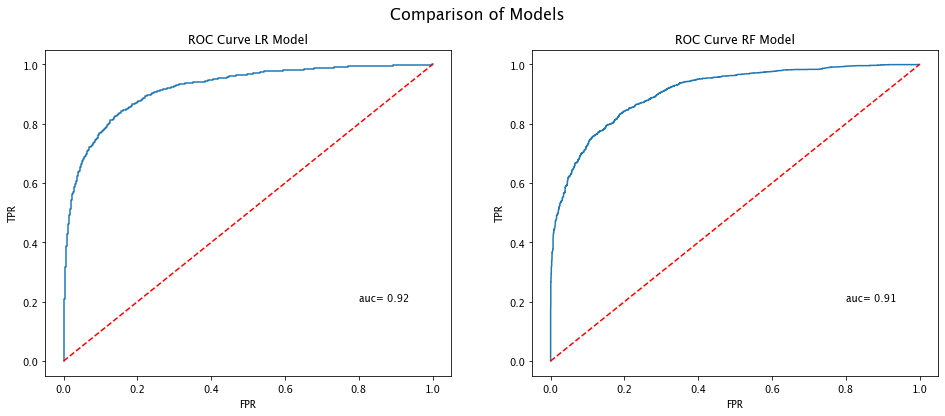

In [262]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# getting the logistic regression model prediction probabilities and labels
lr_prob_1 = lr_pred.rdd.map(lambda x: float(x.probability[1])).collect()
lr_dvbucket = lr_pred.rdd.map(lambda x: float(x.DVBucket)).collect()

# getting the random forest model prediction probabilities and labels
rc_prob_1 = rc_pred.rdd.map(lambda x: float(x.probability[1])).collect()
rc_dvbucket = rc_pred.rdd.map(lambda x: float(x.DVBucket)).collect()

fig, axes = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Comparison of Models", fontsize=16)
axes[0].set_title("ROC Curve LR Model")
axes[1].set_title("ROC Curve RF Model")


### ROC Curve LR Model
lr_fpr, lr_tpr, _ = roc_curve(lr_dvbucket, lr_prob_1)

axes[0].plot(lr_fpr, lr_tpr)
axes[0].plot([0,1], [0,1], linestyle='--', color='r')
axes[0].annotate("auc= {:.2f}".format(lr_areaROC), xy=(0.8, 0.2))
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")

### ROC Curve RF Model
rc_fpr, rc_tpr, _ = roc_curve(rc_dvbucket, rc_prob_1)

axes[1].plot(rc_fpr, rc_tpr)
axes[1].plot([0,1], [0,1], linestyle='--', color='r')
axes[1].annotate("auc= {:.2f}".format(rc_areaROC), xy=(0.8, 0.2))
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")

plt.show();